In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('Online Retail.xlsx')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

# Treat Missing Data

In [5]:
# check for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# Since we have sufficient data, we will drop all the rows with missing values.
# remove missing values
df.dropna(inplace=True)

# again check missing values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

# Data Preparation

In [7]:
#Let's convert the StockCode to string datatype.
df['StockCode']= df['StockCode'].astype(str)


In [8]:
#Let's check out the number of unique customers in our dataset.

customers = df["CustomerID"].unique().tolist()
len(customers)

4372

In [9]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

In [10]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|████████████████████████████████████████████████████████████████████████████| 3935/3935 [00:03<00:00, 1152.68it/s]


In [11]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████████████████████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 1206.91it/s]


# word2vec Embeddings for Products

In [12]:
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3601122, 3637280)

In [13]:
model.save("word2vec_2.model")

In [14]:
#calling init_sims(), which will make the model much more memory-efficient.

model.init_sims(replace=True)

In [16]:
print(model)

Word2Vec(vocab=3167, size=100, alpha=0.03)


In [17]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3167, 100)

# word2vec Embeddings

In [18]:
import umap


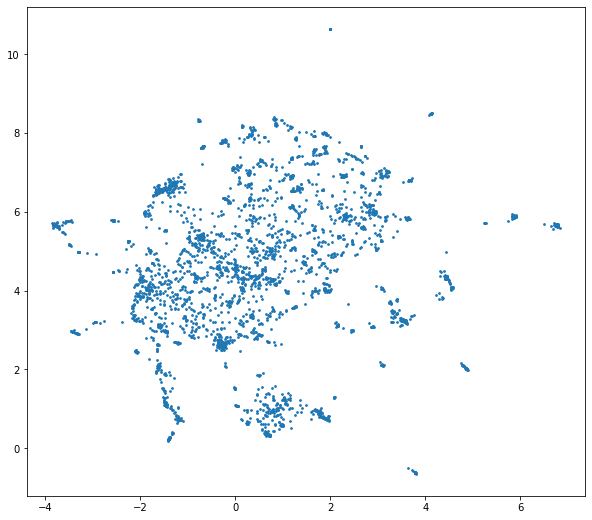

In [19]:
cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

# Recommending Products



In [20]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [21]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

In [22]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms

In [23]:
similar_products(model['90019A'])

[('SILVER M.O.P ORBIT DROP EARRINGS', 0.7811247110366821),
 ('BLUE MURANO TWIST BRACELET', 0.7772083878517151),
 ('PINK BOUDICCA LARGE BRACELET', 0.7742977142333984),
 ('GOLD/M.O.P PENDANT ORBIT NECKLACE', 0.75371253490448),
 ('GREEN HEART OF GLASS BRACELET', 0.7484433650970459),
 ('ANT COPPER RED BOUDICCA BRACELET', 0.7468986511230469)]

In [24]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [25]:
len(purchases_val[0])


251

In [26]:

aggregate_vectors(purchases_val[0]).shape

(100,)

In [27]:
similar_products(aggregate_vectors(purchases_val[0]))

[('MINI PAINT SET VINTAGE ', 0.7021687030792236),
 ('RED TOADSTOOL LED NIGHT LIGHT', 0.6996139287948608),
 ('ROUND SNACK BOXES SET OF 4 FRUITS ', 0.6981344223022461),
 ('SET/6 RED SPOTTY PAPER CUPS', 0.6979234218597412),
 ('SPACEBOY LUNCH BOX ', 0.6887193918228149),
 ('BOYS ALPHABET IRON ON PATCHES', 0.6886723637580872)]

In [28]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('LUNCH BOX WITH CUTLERY RETROSPOT ', 0.7343502044677734),
 ('ROUND SNACK BOXES SET OF 4 FRUITS ', 0.7154370546340942),
 ('STRAWBERRY LUNCH BOX WITH CUTLERY', 0.7103704214096069),
 ('CHILDRENS APRON SPACEBOY DESIGN', 0.6829161643981934),
 ('POSTAGE', 0.6740428805351257),
 ('SPACEBOY LUNCH BOX ', 0.6652474403381348)]